In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pickle

from sklearn.preprocessing import StandardScaler

In [7]:
import csv
from binance.client import Client

API_KEY = 'M383JsArM1hONvFI5B5yenGWAv3fe2N97J1Lxa7ylqPE2fZERCOhy3K4uJwMsFT5'
API_SECRET = 'Yvde8q4bBfLT9bZQrRRpwt8Gb9Uj3EfETjIpnuCVW7uU705HXNUQxFgpIrO6XXbe'

client = Client(API_KEY, API_SECRET)


btc_candlesticks = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2020", "15 Jul, 2021")
eth_candlesticks = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2020", "15 Jul, 2021")
bnb_candlesticks = client.get_historical_klines("BNBUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2020", "15 Jul, 2021")
ada_candlesticks = client.get_historical_klines("ADAUSDT", Client.KLINE_INTERVAL_4HOUR, "1 Dec, 2020", "15 Jul, 2021")

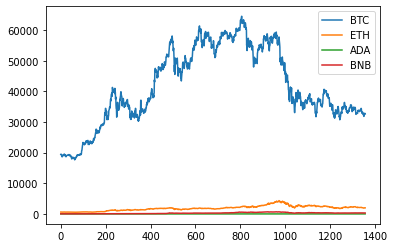

In [8]:
btc=[]
eth=[]
ada=[]
bnb=[]

for i in range(len(btc_candlesticks)):
    btc.append(np.array(btc_candlesticks[i][4]))
    eth.append(np.array(eth_candlesticks[i][4]))
    ada.append(np.array(ada_candlesticks[i][4]))
    bnb.append(np.array(bnb_candlesticks[i][4]))
    
btc=[float(i) for i in btc]
eth=[float(i) for i in eth]
ada=[float(i) for i in ada]
bnb=[float(i) for i in bnb]

d = {'BTC': btc, 'ETH': eth, "ADA":ada, "BNB":bnb}
data = pd.DataFrame(data=d)
data.plot()

In [9]:
class MultiStockEnv:

    def __init__(self, data, initial_investment=20000):
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        self.state_dim = self.n_stock * 2 + 1

        self.reset()


    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()


    def step(self, action):
        assert action in self.action_space

        prev_val = self._get_val()

        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]

        self._trade(action)

        cur_val = self._get_val()

        reward = cur_val - prev_val

        done = self.cur_step == self.n_step - 1

        info = {'cur_val': cur_val}

        return self._get_obs(), reward, done, info


    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs
    
    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

    def _trade(self, action):

        action_vec = self.action_list[action]

        sell_index = [] 
        buy_index = [] 
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        if sell_index:
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if buy_index:

            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1 
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False

In [10]:
n_timesteps, n_stocks = data.shape

In [11]:
n_train = n_timesteps // 2
n_train

678

In [12]:
train_data = data[:n_train].values
test_data = data[n_train:].values

In [13]:
env = MultiStockEnv(train_data,initial_investment=20000)
env.reset()

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.941974e+04, 6.051400e+02, 1.682900e-01, 3.121020e+01,
       2.000000e+04])

In [14]:
def predict(X,W,b):
    assert(len(X.shape) == 2)
    return X.dot(W) + b

In [15]:
def sgd(X, Y,W,b,vW,vb,learning_rate=0.01, momentum=0.9):
    assert(len(X.shape) == 2)

    num_values = np.prod(Y.shape)

    Yhat = predict(X,W,b)
    gW = 2 * X.T.dot(Yhat - Y) / num_values
    gb = 2 * (Yhat - Y).sum(axis=0) / num_values

    vW = momentum * vW - learning_rate * gW
    vb = momentum * vb - learning_rate * gb

    W += vW
    b += vb
    return W,b,vW,vb

In [16]:
def greedy_policy(state,W,b,epsilon):
    if np.random.rand() <= epsilon:
        return np.random.choice(action_size)
    else:
        act_values = predict(state,W,b)
        return np.argmax(act_values[0])  

In [17]:
def get_scaler(env):
    states = []
    for i in range(100):
        for j in range(env.n_step):
            action = np.random.choice(env.action_space)
            state, reward, done, info = env.step(action)
            states.append(state)
            if done:
                env.reset()
                break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

In [18]:
gamma = 0.95  
epsilon = 1.0  
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 2000
initial_investment = 20000

n_timesteps, n_stocks = data.shape
n_train = n_timesteps // 2
train_data = data[:n_train].values
test_data = data[n_train:].values
np.random.seed(1)
env = MultiStockEnv(train_data,initial_investment=20000)
state_size = env.state_dim
action_size = len(env.action_space)
W = np.random.randn(state_size, action_size) / np.sqrt(state_size)
b = np.zeros(action_size)

scaler=get_scaler(env)
vW = 0
vb = 0

portfolio_value = []
for i in range(num_episodes):
    done=False
    state = env.reset()
    state = scaler.transform([state])
    while not done:
        action = greedy_policy(state,W,b,epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if done:
            target = reward
        else:
            target = reward + gamma * np.amax(predict(next_state,W,b), axis=1)
        target_full = predict(state,W,b)
        target_full[0, action] = target
        W,b,vW,vb=sgd(X=state, Y=target_full,W=W,b=b,vW=vW,vb=vb)
        
        state=next_state
        
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        
    val=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {val:.2f}")
    portfolio_value.append(val)
pickle.dump(scaler, open('scaler.pkl','wb'))
np.savez("TraderWeights.npz", W=W, b=b)

episode: 1/2000, episode end value: 82415.71
episode: 2/2000, episode end value: 196697.08
episode: 3/2000, episode end value: 159049.80
episode: 4/2000, episode end value: 145788.99
episode: 5/2000, episode end value: 181515.66
episode: 6/2000, episode end value: 149118.67
episode: 7/2000, episode end value: 120935.48
episode: 8/2000, episode end value: 102696.75
episode: 9/2000, episode end value: 153903.59
episode: 10/2000, episode end value: 163422.60
episode: 11/2000, episode end value: 115994.58
episode: 12/2000, episode end value: 154805.51
episode: 13/2000, episode end value: 169949.09
episode: 14/2000, episode end value: 161687.31
episode: 15/2000, episode end value: 190603.69
episode: 16/2000, episode end value: 160500.12
episode: 17/2000, episode end value: 159708.63
episode: 18/2000, episode end value: 120732.18
episode: 19/2000, episode end value: 213123.09
episode: 20/2000, episode end value: 161728.87
episode: 21/2000, episode end value: 175505.16
episode: 22/2000, episo

In [19]:
scaler = pickle.load(open('scaler.pkl', 'rb'))
npz = np.load("TraderWeights.npz")
W = npz['W']
b = npz['b']

In [20]:
np.random.seed(1)
-epsilon = 0.01
env = MultiStockEnv(test_data, initial_investment)
testportfoliovalues=[]
for i in range(num_episodes):
    state = env.reset()
    state = scaler.transform([state])
    done=False
    while not done:
        action = greedy_policy(state,W,b,epsilon=epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
    value=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {value:.2f}")
    testportfoliovalues.append(value) 

episode: 1/2000, episode end value: 9754.30
episode: 2/2000, episode end value: 10126.66
episode: 3/2000, episode end value: 10272.90
episode: 4/2000, episode end value: 10032.83
episode: 5/2000, episode end value: 11699.05
episode: 6/2000, episode end value: 9185.49
episode: 7/2000, episode end value: 11027.65
episode: 8/2000, episode end value: 10097.03
episode: 9/2000, episode end value: 10169.34
episode: 10/2000, episode end value: 11572.45
episode: 11/2000, episode end value: 11713.51
episode: 12/2000, episode end value: 12438.18
episode: 13/2000, episode end value: 10119.28
episode: 14/2000, episode end value: 10671.65
episode: 15/2000, episode end value: 11158.48
episode: 16/2000, episode end value: 9888.82
episode: 17/2000, episode end value: 11100.88
episode: 18/2000, episode end value: 11143.59
episode: 19/2000, episode end value: 9870.98
episode: 20/2000, episode end value: 11358.18
episode: 21/2000, episode end value: 10114.41
episode: 22/2000, episode end value: 9910.13
ep

In [21]:
np.random.seed(1)
epsilon = 1
env = MultiStockEnv(test_data, initial_investment)
randomportfoliovalues=[]
for i in range(num_episodes):
    state = env.reset()
    state = scaler.transform([state])
    done=False
    while not done:
        action = greedy_policy(state,W,b,epsilon=epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
    value=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {value:.2f}")
    randomportfoliovalues.append(value) 

episode: 1/2000, episode end value: 24293.81
episode: 2/2000, episode end value: 19065.62
episode: 3/2000, episode end value: 37609.02
episode: 4/2000, episode end value: 34678.02
episode: 5/2000, episode end value: 15648.64
episode: 6/2000, episode end value: 21269.07
episode: 7/2000, episode end value: 33381.22
episode: 8/2000, episode end value: 37587.04
episode: 9/2000, episode end value: 39553.47
episode: 10/2000, episode end value: 24258.30
episode: 11/2000, episode end value: 18417.70
episode: 12/2000, episode end value: 11681.23
episode: 13/2000, episode end value: 44545.94
episode: 14/2000, episode end value: 39914.67
episode: 15/2000, episode end value: 22186.30
episode: 16/2000, episode end value: 19983.74
episode: 17/2000, episode end value: 37567.97
episode: 18/2000, episode end value: 10454.85
episode: 19/2000, episode end value: 22690.62
episode: 20/2000, episode end value: 31708.32
episode: 21/2000, episode end value: 18697.38
episode: 22/2000, episode end value: 22681.

In [22]:
np.savez("TraderPortfolios.npz", TrainingPortfolio=portfolio_value, 
         TestPortfolio=testportfoliovalues,
         RandomPortfolio=randomportfoliovalues)

In [23]:
npz = np.load("TraderPortfolios.npz")
TrainingPortfolio=npz['TrainingPortfolio']
RandomPortfolio=npz['RandomPortfolio']
TestPortfolio=npz['TestPortfolio']

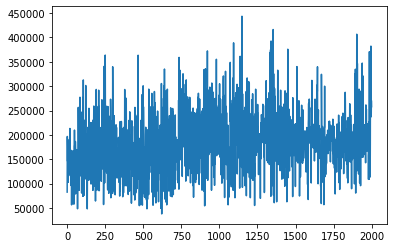

In [24]:
plt.plot(TrainingPortfolio)

(array([ 68., 190., 347., 662., 425., 196.,  75.,  24.,  10.,   3.]),
 array([ 37631.61130998,  78228.5894234 , 118825.56753681, 159422.54565023,
        200019.52376365, 240616.50187707, 281213.47999049, 321810.45810391,
        362407.43621733, 403004.41433074, 443601.39244416]),
 <a list of 10 Patch objects>)

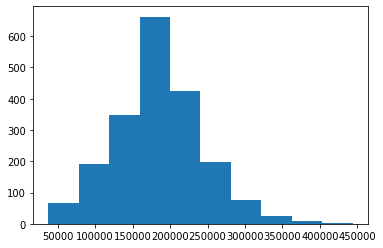

In [25]:
plt.hist(TrainingPortfolio)

In [26]:
np.mean(TestPortfolio)

10874.020362370056

(array([ 111., 1610.,  171.,   16.,   23.,   23.,   27.,   12.,    3.,
           4.]),
 array([ 7305.85524   ,  9351.837898  , 11397.820556  , 13443.803214  ,
        15489.785872  , 17535.76853   , 19581.751188  , 21627.733846  ,
        23673.716504  , 25719.69916201, 27765.68182001]),
 <a list of 10 Patch objects>)

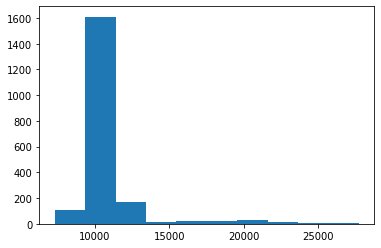

In [27]:
plt.hist(TestPortfolio)

(array([104., 512., 567., 378., 248., 134.,  39.,  11.,   4.,   3.]),
 array([ 5534.47800002, 11929.19886603, 18323.91973205, 24718.64059806,
        31113.36146408, 37508.0823301 , 43902.80319611, 50297.52406213,
        56692.24492815, 63086.96579416, 69481.68666018]),
 <a list of 10 Patch objects>)

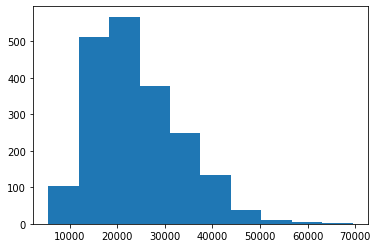

In [28]:
plt.hist(RandomPortfolio)

In [29]:
np.mean(RandomPortfolio)

24112.391812843136

In [30]:
test_data[-1]

array([3.264165e+04, 1.979280e+03, 1.243800e+00, 3.061400e+02])

In [31]:
PercentIncrease=(test_data[-1]-test_data[0])/test_data[0]

In [32]:
np.mean(PercentIncrease)

0.02432508676568674